# Import Libraries

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import tweepy
import requests
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline
pd.options.display.max_colwidth = 280

# Gathering Data

### 1. Manual Download

In [2]:
# Twitter Archive Enhanced data manually downloaded
t_archives = pd.read_csv('twitter-archive-enhanced.csv')

### 2. Programmatic Download

In [37]:
# Progammatically download Tweet Image Predictions tsv from Udacity servers
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

with open('image-predictions.tsv', mode = 'wb') as file:
    file.write(response.content)

t_images = pd.read_csv('image-predictions.tsv', sep = '\t')

### 3. Use Twitter API for additional data

In [38]:
# Use API to scrape data for additional WeRateDogs data

import tweepy

consumer_key = 'CONSUMER KEY HERE'
consumer_secret = 'CONSUMER SECRET HERE'
access_token = 'ACCESS TOKEN HERE'
access_secret = 'ACCESS SECRET HERE'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth_handler=auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)


In [39]:
# Create list of ID's to scrape using existing ids in images df
t_idList = list(t_images.tweet_id)

# Loop that will take json for each ID and add it to the tweet_json.txt file
with open('tweet_json.txt', "w", encoding="utf8") as file:
    data_list = []
    for ids in t_idList:
        try:
            working_ids = api.get_status(ids, tweet_mode = 'extended')._json
            data_list.append(working_ids)
        except Exception as e:
            print(e)
    json.dump(data_list,file, indent= 4)
    file.close()

Rate limit reached. Sleeping for: 681
Rate limit reached. Sleeping for: 717
[{'code': 144, 'message': 'No status found with that ID.'}]
[{'code': 144, 'message': 'No status found with that ID.'}]
[{'code': 144, 'message': 'No status found with that ID.'}]
[{'code': 144, 'message': 'No status found with that ID.'}]
[{'code': 144, 'message': 'No status found with that ID.'}]
[{'code': 144, 'message': 'No status found with that ID.'}]


In [4]:
#Read tweet_json.txt and load it as an object in Pandas
with open('tweet_json.txt') as json_file:  
    tweet_json = json.load(json_file)

In [5]:
# Create dataframe from tweet_json using columns of interest
tj_df = pd.DataFrame(tweet_json, columns = ['id', 'retweet_count', 'favorite_count','full_text'])

# Assessing Data

* According to key points, we only want original ratings (no retweets) that have images!
    * need to filter out only dog ratings and only ids that have images associated with them!
* Don't do extensive cleaning on dog rating info!

### tweet_json assessment

In [6]:
tj_df.head()

,id,retweet_count,favorite_count,full_text
0,666020888022790149,521,2559,Here we have a Japanese Irish Setter. Lost eye in Vietnam (?). Big fan of relaxing on stair. 8/10 would pet https://t.co/BLDqew2Ijj
1,666029285002620928,47,131,This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI
2,666033412701032449,45,125,Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR
3,666044226329800704,141,301,This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx
4,666049248165822465,40,109,Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq


In [7]:
tj_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2069 entries, 0 to 2068
Data columns (total 4 columns):
id                2069 non-null int64
retweet_count     2069 non-null int64
favorite_count    2069 non-null int64
full_text         2069 non-null object
dtypes: int64(3), object(1)
memory usage: 64.7+ KB


In [8]:
tj_df.isnull().sum()

id                0
retweet_count     0
favorite_count    0
full_text         0
dtype: int64

In [9]:
tj_df.duplicated().sum()

0

#### Issues :

* Change id column name to tweet_id to match other dataframes and change to str instead of int
* Less ID's in this dataframe than in the t_images dataframe, means that a few posts have been deleted
* use full_text in final dataframe instead of text info from the archive

### Twitter Images assessment

In [10]:
t_images.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [11]:
t_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [12]:
t_images.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

#### Issues

* tweet_id is an integer, should convert to string
* need to use this dataframe to filter out other dataframes
* Establish method as to how to combine dfs together (Perhaps use tweet_id)

### Twitter Archive assessment

In [13]:
t_archives.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None


In [14]:
t_archives.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [15]:
t_archives[t_archives['rating_denominator'] != 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1",84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1",24,7,Sam,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,"https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",9,11,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244762497024/video/1,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023742988288/photo/1,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582966214656/photo/1,4,20,None,None,None,None,None
1202,716439118184

#### Issues

* tweet_id as int, need to convert to string
* convert timestamp to datetime
* need to filter out tweet_ids that arent in the t_images dataframe
* Should tidy up dog type (doggo, floofer, pupper, puppo)
* Filter out any retweets/ only ratings
* Drop retweeted status id/user_id/timestamp columns
* Look into some denominator values that arent 10 and try to adjust
    * Some user error in this, will adjust for the ones that I can
        * User input for tweet_id == '722974582966214656' (4/20 instead of 13/10)
        * User input for tweet_id == '682962037429899265' (7/11 instaed of 10/10)
        * Error in scraping data for tweet_id == '666287406224695296', should be (9/10 not 1/2)
        * '667878741721415682'
        * '691483041324204033'
        * '695064344191721472'
        * '883482846933004288'
        * '695064344191721472'
        * '740373189193256964' 
* Look into numerators and see if theres any visible errors
* Text info in archive is not complete, will merge full text info from tweet_json 
* Questionable keeping in_reply_to columns, may take them out in the future. Can convert to strings for the time being.

# Cleaning Data

* First off, need to make copies of original dataframes and save them as _clean copies. Keep original dataframes intact!

In [6]:
tj_df_clean = tj_df.copy()
t_images_clean = t_images.copy()
t_archives_clean = t_archives.copy()

### Issue/Test/Clean steps

#### Issue: Change Id in twitter_json dataframe to tweet id and convert to string instead of integer

#### Test:

In [7]:
tj_df_test = tj_df.copy()

# Conversion to string and rename column
tj_df_test.rename(columns={'id':'tweet_id'}, inplace=True)
tj_df_test['tweet_id'] = tj_df_test['tweet_id'].astype(str)

#Check changes
tj_df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2069 entries, 0 to 2068
Data columns (total 4 columns):
tweet_id          2069 non-null object
retweet_count     2069 non-null int64
favorite_count    2069 non-null int64
full_text         2069 non-null object
dtypes: int64(2), object(2)
memory usage: 64.7+ KB


#### Clean:

In [8]:
#Apply test changes to clean df
tj_df_clean.rename(columns={'id':'tweet_id'}, inplace=True)
tj_df_clean['tweet_id'] = tj_df_clean['tweet_id'].astype(str)

#### Issue: Filter out IDs from t_archive based on Ids in the images dataframe using t_idList object made earlier

#### Test:

In [9]:
t_archives_test = t_archives.copy()

# Create list of ID's to scrape using existing ids in images df
t_idList = list(t_images.tweet_id)

mask = t_archives_test['tweet_id'].isin(t_idList)
t_archives_test = t_archives_test.loc[mask]

# Check if changes worked 
t_archives_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2075 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2075 non-null object
source                        2075 non-null object
text                          2075 non-null object
retweeted_status_id           81 non-null float64
retweeted_status_user_id      81 non-null float64
retweeted_status_timestamp    81 non-null object
expanded_urls                 2075 non-null object
rating_numerator              2075 non-null int64
rating_denominator            2075 non-null int64
name                          2075 non-null object
doggo                         2075 non-null object
floofer                       2075 non-null object
pupper                        2075 non-null object
puppo                         2075 non-null object
dtypes: float64(4), int64(3), objec

* Changes worked, now have 2075 rows, down from 2356

#### Clean:

In [10]:
mask = t_archives_clean['tweet_id'].isin(t_idList)
t_archives_clean = t_archives_clean.loc[mask]

#### Issue: Need to filter out those that have a retweeted status_id. Originals Only! Drop retweeted status columns.

#### Test:

In [11]:
t_archives_test = t_archives_clean.copy()

# Filter for reetweets
mask = t_archives_test['retweeted_status_id'].notnull()
t_archives_test = t_archives_test.loc[~mask]

t_archives_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      1994 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     1994 non-null object
source                        1994 non-null object
text                          1994 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1994 non-null object
rating_numerator              1994 non-null int64
rating_denominator            1994 non-null int64
name                          1994 non-null object
doggo                         1994 non-null object
floofer                       1994 non-null object
pupper                        1994 non-null object
puppo                         1994 non-null object
dtypes: float64(4), int64(3), object(1

* Changes removed rows, now have 1994 rows down from 2075

In [12]:
# Drop columns
t_archives_test.drop(['retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp' ],
               axis = 1, inplace = True)

#Check for changes
t_archives_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                 1994 non-null int64
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
timestamp                1994 non-null object
source                   1994 non-null object
text                     1994 non-null object
expanded_urls            1994 non-null object
rating_numerator         1994 non-null int64
rating_denominator       1994 non-null int64
name                     1994 non-null object
doggo                    1994 non-null object
floofer                  1994 non-null object
pupper                   1994 non-null object
puppo                    1994 non-null object
dtypes: float64(2), int64(3), object(9)
memory usage: 233.7+ KB


* Unused columns now gone

#### Clean:

In [13]:
mask = t_archives_clean['retweeted_status_id'].notnull()
t_archives_clean = t_archives_clean.loc[~mask]


t_archives_clean.drop(['retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp' ],
               axis = 1, inplace = True)

#### Issue: Fix some data quality issues in some of the rating entries of the t_archive dataframe
* Some ratings have decimals in them! (13.5/10) Needs to be corrected to include those in the ratings
* Specific User Tweets have quality issues
* Set numerator and denominator as strings

#### Test:

In [42]:
t_archives_test = t_archives_clean.copy()

In [43]:
# Set rating_numerator and denominator as strings
t_archives_test['rating_numerator'] = t_archives_test['rating_numerator'].astype(str)
t_archives_test['rating_denominator'] = t_archives_test['rating_denominator'].astype(str)

In [44]:
# Code will strip text data from each tweet and ensure that ratings with decimals are kept
t_archives_test['rating_numerator'] = t_archives_test.text.str.extract('(\d+.?\d*/+)').str.strip('/')
t_archives_test.rating_numerator.value_counts()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  


12       450
10       419
11       396
13       261
9        151
8         95
7         52
14        35
5         32
6         32
3         19
4         16
2          9
1          4
0          2
88         1
204        1
165        1
144        1
84         1
121        1
44         1
50         1
13.5       1
60         1
11.26      1
9.75       1
420        1
1776       1
143        1
80         1
99         1
11.27      1
24         1
45         1
3 1        1
Name: rating_numerator, dtype: int64

Extreme values, some of them are because of multiple pups and will therefore have a larger numerator and denominator. Others are simply errors. will correct

In [59]:
# Data Quality Issues being cleaned

# User input for tweet_id == '722974582966214656' (4/20 instead of 13/10)
masker = t_archives_test['tweet_id'] == 722974582966214656
columns = ['rating_numerator', 'rating_denominator']
t_archives_test.loc[masker,columns]  = ['13','10']

# User input for tweet_id == '682962037429899265' (7/11 instead of 10/10)
masker = t_archives_test['tweet_id'] == 682962037429899265
columns = ['rating_numerator', 'rating_denominator']
t_archives_test.loc[masker,columns] = ['10','10']

# Error in scraping data for tweet_id == '666287406224695296', should be 9/10 not '3 1'
masker = t_archives_test['tweet_id'] == 666287406224695296
columns = ['rating_numerator', 'rating_denominator']
t_archives_test.loc[masker,columns] = ['9','10']

# Error in scraping data for rating_numerator == 50
masker = t_archives_test['rating_numerator'] == '50'
columns = ['rating_numerator', 'rating_denominator']
t_archives_test.loc[masker,columns] = ['11','10']

# Error in scraping data for tweet_id == '810984652412424192', NOT A RATING!
t_archives_test = t_archives_test[t_archives_test['tweet_id'] != 810984652412424192]

# Drop values that have a rating_numerator of zero, one is not a rating of a dog, the other complaining about reposts
t_archives_test = t_archives_test[t_archives_test['rating_numerator'] != '0']

# Error in scraping data for tweet_id == '667878741721415682', should be 12/10 not 10 & 2/10
masker = t_archives_test['tweet_id'] == 667878741721415682
columns = ['rating_numerator', 'rating_denominator']
t_archives_test.loc[masker,columns] = ['12','10']

# Error in scraping data for tweet_id == '691483041324204033', should be 10/10 not 5/10
masker = t_archives_test['tweet_id'] == 691483041324204033
columns = ['rating_numerator', 'rating_denominator']
t_archives_test.loc[masker,columns] = ['10','10']

# Error in scraping data for tweet_id == '695064344191721472', should be 13/10 not 4/10
masker = t_archives_test['tweet_id'] == 695064344191721472
columns = ['rating_numerator', 'rating_denominator']
t_archives_test.loc[masker,columns] = ['13','10']

# Error in scraping data for tweet_id == '740373189193256964', should be 14/10 not 9/11
masker = t_archives_test['tweet_id'] == 740373189193256964
columns = ['rating_numerator', 'rating_denominator']
t_archives_test.loc[masker,columns] = ['14','10']


In [60]:
t_archives_test[(t_archives_test['tweet_id'] == 722974582966214656) |
               (t_archives_test['tweet_id'] == 682962037429899265)|
               (t_archives_test['tweet_id'] == 666287406224695296)|
               (t_archives_test['tweet_id'] == 667878741721415682)|
               (t_archives_test['tweet_id'] == 691483041324204033)|
               (t_archives_test['tweet_id'] == 695064344191721472)|
               (t_archives_test['tweet_id'] == 740373189193256964)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ","https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",14,10,None,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,https://twitter.com/dog_rates/status/722974582966214656/photo/1,13,10,None,None,None,None,None
1459,695064344191721472,NaN,NaN,2016-02-04 02:00:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This may be the greatest video I've ever been sent. 4/10 for Charles the puppy, 13/10 overall. (Vid by @stevenxx_) https://t.co/uaJmNgXR2P",https://twitter.com/dog_rates/status/695064344191721472/video/1,13,10,None,None,None,None,None
1508,691483041324204033,NaN,NaN,2016-01-25 04:49:38 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When bae says they can't go out but you see them with someone else that same night. 5/10 &amp; 10/10 for heartbroken pup https://t.co/aenk0KpoWM,"https://twitter.com/dog_rates/status/691483041324204033/photo/1,https://twitter.com/dog_rates/status/691483041324204033/photo/1,https://twitter.com/dog_rates/status/691483041324204033/photo/1,https://twitter.com/dog_rates/status/691483041324204033/photo/1",10,10,None,None,None,None,None
1662,682962037429899265,NaN,NaN,2016-01-01 16:30:13 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5,https://twitter.com/dog_rates/status/682962037429899265/photo/1,10,10,Darrel,None,None,None,None
2246,667878741721415682,NaN,NaN,2015-11-21 01:34:35 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Tedrick. He lives on the edge. Needs someone to hit the gas tho. Other than that he's a baller. 10&amp;2/10 https://t.co/LvP1TTYSCN,https://twitter.com/dog_rates/status/667878741721415682/photo/1,12,10,Tedrick,None,None,None,None
2335,666287406224695296,NaN,NaN,2015-11-16 16:11:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,https://twitter.com/dog_rates/status/666287406224695296/photo/1,9,10,an,None,None,None,None


In [61]:
t_archives_test.rating_numerator.value_counts()

12       451
10       421
11       397
13       263
9        151
8         95
7         51
14        36
6         32
5         31
3         19
4         14
2          8
1          4
88         1
121        1
84         1
144        1
204        1
44         1
11.26      1
13.5       1
60         1
9.75       1
420        1
1776       1
143        1
80         1
99         1
11.27      1
45         1
165        1
Name: rating_numerator, dtype: int64

#### Clean:

In [62]:
# Set rating_numerator and denominator as strings
t_archives_clean['rating_numerator'] = t_archives_clean['rating_numerator'].astype(str)
t_archives_clean['rating_denominator'] = t_archives_clean['rating_denominator'].astype(str)

# Code will strip text data from each tweet and ensure that ratings with decimals are kept
t_archives_clean['rating_numerator'] = t_archives_clean.text.str.extract('(\d+.?\d*/+)').str.strip('/')

# User input for tweet_id == '722974582966214656' (4/20 instead of 13/10)
masker = t_archives_clean['tweet_id'] == 722974582966214656
columns = ['rating_numerator', 'rating_denominator']
t_archives_clean.loc[masker,columns]  = ['13','10']

# User input for tweet_id == '682962037429899265' (7/11 instead of 10/10)
masker = t_archives_clean['tweet_id'] == 682962037429899265
columns = ['rating_numerator', 'rating_denominator']
t_archives_clean.loc[masker,columns] = ['10','10']

# Error in scraping data for tweet_id == '666287406224695296', should be 9/10 not 1/2
masker = t_archives_clean['tweet_id'] == 666287406224695296
columns = ['rating_numerator', 'rating_denominator']
t_archives_clean.loc[masker,columns] = ['9','10']

# Error in scraping data for rating_numerator == 50
masker = t_archives_clean['rating_numerator'] == '50'
columns = ['rating_numerator', 'rating_denominator']
t_archives_clean.loc[masker,columns] = ['11','10']

# Error in scraping data for tweet_id == '810984652412424192', NOT A RATING!
t_archives_clean = t_archives_clean[t_archives_clean['tweet_id'] != 810984652412424192]

# Drop values that have a rating_numerator of zero, one is not a rating of a dog, the other complaining about reposts
t_archives_clean = t_archives_clean[t_archives_clean['rating_numerator'] != '0']

# Error in scraping data for tweet_id == '667878741721415682', should be 12/10 not 10 & 2/10
masker = t_archives_clean['tweet_id'] == 667878741721415682
columns = ['rating_numerator', 'rating_denominator']
t_archives_clean.loc[masker,columns] = ['12','10']

# Error in scraping data for tweet_id == '691483041324204033', should be 10/10 not 5/10
masker = t_archives_clean['tweet_id'] == 691483041324204033
columns = ['rating_numerator', 'rating_denominator']
t_archives_clean.loc[masker,columns] = ['10','10']

# Error in scraping data for tweet_id == '695064344191721472', should be 13/10 not 4/10
masker = t_archives_clean['tweet_id'] == 695064344191721472
columns = ['rating_numerator', 'rating_denominator']
t_archives_clean.loc[masker,columns] = ['13','10']

# Error in scraping data for tweet_id == '740373189193256964', should be 14/10 not 9/11
masker = t_archives_clean['tweet_id'] == 740373189193256964
columns = ['rating_numerator', 'rating_denominator']
t_archives_clean.loc[masker,columns] = ['14','10']


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  


#### Issue : Convert data types to proper ones for certain columns. 
* Convert tweet_ids in all dataframes to strings instead of integers
* Convert in_reply_to columns in t_archives dataframe from float to string
* Convert timestamp to DateTime object in t_archives

#### Test:

In [63]:
t_archives_test = t_archives_clean.copy()
t_images_test = t_images_clean.copy()
tj_df_test = tj_df_clean.copy()

# Convert tweet_ids to strings
t_archives_test['tweet_id'] = t_archives_test['tweet_id'].astype(str)
t_images_test['tweet_id'] = t_images_test['tweet_id'].astype(str)
tj_df_test['tweet_id'] = tj_df_test['tweet_id'].astype(str)

In [64]:
# Convert in_reply_to columns in t_archives dataframe from float to string
t_archives_test['in_reply_to_status_id'] = t_archives_test['in_reply_to_status_id'].astype(str)
t_archives_test['in_reply_to_user_id'] = t_archives_test['in_reply_to_user_id'].astype(str)

In [65]:
# Convert timestamp to DateTime object in t_archives
t_archives_test.timestamp = pd.to_datetime(t_archives_test.timestamp)

In [66]:
t_archives_test.info()
tj_df_test.info()
t_images_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1991 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                 1991 non-null object
in_reply_to_status_id    1991 non-null object
in_reply_to_user_id      1991 non-null object
timestamp                1991 non-null datetime64[ns]
source                   1991 non-null object
text                     1991 non-null object
expanded_urls            1991 non-null object
rating_numerator         1991 non-null object
rating_denominator       1991 non-null object
name                     1991 non-null object
doggo                    1991 non-null object
floofer                  1991 non-null object
pupper                   1991 non-null object
puppo                    1991 non-null object
dtypes: datetime64[ns](1), object(13)
memory usage: 233.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2069 entries, 0 to 2068
Data columns (total 4 columns):
tweet_id          2069 non-null object
retweet_count     2069 non-null in

#### Clean:

In [67]:
# Convert tweet_ids in all dataframes to strings instead of integers
t_archives_clean['tweet_id'] = t_archives_clean['tweet_id'].astype(str)
t_images_clean['tweet_id'] = t_images_clean['tweet_id'].astype(str)
tj_df_clean['tweet_id'] = tj_df_clean['tweet_id'].astype(str)

In [68]:
# Convert in_reply_to columns in t_archives dataframe from float to string
t_archives_clean['in_reply_to_status_id'] = t_archives_clean['in_reply_to_status_id'].astype(str)
t_archives_clean['in_reply_to_user_id'] = t_archives_clean['in_reply_to_user_id'].astype(str)

In [69]:
# Convert timestamp to DateTime object in t_archives
t_archives_clean.timestamp = pd.to_datetime(t_archives_clean.timestamp)

#### Issue: Tidy up t_archive by consolidating dog types into one column and dropping redundant columns from df

#### Test:

In [70]:
t_archives_test = t_archives_clean.copy()

# Tidy up t_archive by consolidating dog type columns into one
t_archives_test['dog_type'] = (t_archives_test.doggo+ t_archives_test.floofer +
                               t_archives_test.pupper + t_archives_test.puppo)

# Clean up strings to leave just dog_type info
t_archives_test['dog_type'] = t_archives_test['dog_type'].str.replace('NoneNoneNone', '')
t_archives_test['dog_type'] = t_archives_test['dog_type'].str.replace('NoneNonepupperNone', 'pupper')
t_archives_test['dog_type'] = t_archives_test['dog_type'].str.replace('doggoNonepupperNone', 'doggo/pupper')
t_archives_test['dog_type'] = t_archives_test['dog_type'].str.replace('doggoflooferNoneNone', 'doggo/floofer')
t_archives_test['dog_type'] = t_archives_test['dog_type'].str.replace('doggoNoneNonepuppo', 'doggo/puppo')
t_archives_test['dog_type'] = t_archives_test['dog_type'].str.replace('NoneflooferNoneNone', 'floofer')

# Drop redundant columns from dataframe
t_archives_test.drop(['doggo','floofer','pupper','puppo'], axis =1, inplace = True)

# Set dog_type as category
t_archives_test.dog_type = t_archives_test.dog_type.astype('category')

In [71]:
t_archives_test.info()
t_archives_test.dog_type.value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1991 entries, 0 to 2355
Data columns (total 11 columns):
tweet_id                 1991 non-null object
in_reply_to_status_id    1991 non-null object
in_reply_to_user_id      1991 non-null object
timestamp                1991 non-null datetime64[ns]
source                   1991 non-null object
text                     1991 non-null object
expanded_urls            1991 non-null object
rating_numerator         1991 non-null object
rating_denominator       1991 non-null object
name                     1991 non-null object
dog_type                 1991 non-null category
dtypes: category(1), datetime64[ns](1), object(9)
memory usage: 173.4+ KB


None             1685
pupper            203
doggo              63
puppo              22
doggo/pupper        9
floofer             7
doggo/puppo         1
doggo/floofer       1
Name: dog_type, dtype: int64

#### Fix new issue: Some "hybrid" type dogs. Floofers can be all dogs but not all dogs are puppers/puppos/doggos

In [72]:
t_archives_test['dog_type'] = t_archives_test['dog_type'].str.replace('doggo/pupper', 'puppo')
t_archives_test['dog_type'] = t_archives_test['dog_type'].str.replace('doggo/puppo', 'doggo')

t_archives_test.dog_type.value_counts()

None             1685
pupper            203
doggo              64
puppo              31
floofer             7
doggo/floofer       1
Name: dog_type, dtype: int64

#### Clean:

In [73]:
# Tidy up t_archive by consolidating dog type columns into one
t_archives_clean['dog_type'] = (t_archives_clean.doggo+ t_archives_clean.floofer +
                               t_archives_clean.pupper + t_archives_clean.puppo)

# Clean up strings to leave just dog_type info
t_archives_clean['dog_type'] = t_archives_clean['dog_type'].str.replace('NoneNoneNone', '')
t_archives_clean['dog_type'] = t_archives_clean['dog_type'].str.replace('NoneNonepupperNone', 'pupper')
t_archives_clean['dog_type'] = t_archives_clean['dog_type'].str.replace('doggoNonepupperNone', 'doggo/pupper')
t_archives_clean['dog_type'] = t_archives_clean['dog_type'].str.replace('doggoflooferNoneNone', 'doggo/floofer')
t_archives_clean['dog_type'] = t_archives_clean['dog_type'].str.replace('doggoNoneNonepuppo', 'doggo/puppo')
t_archives_clean['dog_type'] = t_archives_clean['dog_type'].str.replace('NoneflooferNoneNone', 'floofer')

# Fix for"hybrid" type dogs. Floofers can be all dogs but not all dogs are puppers/puppos/doggos
t_archives_clean['dog_type'] = t_archives_clean['dog_type'].str.replace('doggo/pupper', 'puppo')
t_archives_clean['dog_type'] = t_archives_clean['dog_type'].str.replace('doggo/puppo', 'doggo')


# Drop redundant columns from dataframe
t_archives_clean.drop(['doggo','floofer','pupper','puppo'], axis =1, inplace = True)

# Set dog_type as category
t_archives_clean.dog_type = t_archives_clean.dog_type.astype('category')

#### Issue: Tidy up t_archive by consolidating ratings into one column and keeping it as a string

#### Test:

In [74]:
t_archives_test = t_archives_clean.copy()


t_archives_test['rating_numerator'] = (t_archives_test['rating_numerator'] 
                                       + '/' + t_archives_test['rating_denominator'])

t_archives_test.rename(columns={'rating_numerator':'rating'}, inplace=True)
t_archives_test.drop('rating_denominator', axis = 1, inplace = True)

t_archives_test.info()
t_archives_test.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1991 entries, 0 to 2355
Data columns (total 10 columns):
tweet_id                 1991 non-null object
in_reply_to_status_id    1991 non-null object
in_reply_to_user_id      1991 non-null object
timestamp                1991 non-null datetime64[ns]
source                   1991 non-null object
text                     1991 non-null object
expanded_urls            1991 non-null object
rating                   1991 non-null object
name                     1991 non-null object
dog_type                 1991 non-null category
dtypes: category(1), datetime64[ns](1), object(8)
memory usage: 157.7+ KB


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating,name,dog_type
0,892420643555336193,nan,nan,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13/10,Phineas,None
1,892177421306343426,nan,nan,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13/10,Tilly,None


#### Clean:

In [75]:
# Tidy up t_archive by consolidating ratings into one column

t_archives_clean['rating_numerator'] = (t_archives_clean['rating_numerator'] 
                                       + '/' + t_archives_clean['rating_denominator'])

t_archives_clean.rename(columns={'rating_numerator':'rating'}, inplace=True)
t_archives_clean.drop('rating_denominator', axis = 1, inplace = True)

## Merging Cleaned Dataframes into Master

Before we begin, lets take a look at each of the three cleaned dataframes

In [86]:
t_archives_clean.info()
t_archives_clean.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 10 columns):
tweet_id                 1994 non-null object
in_reply_to_status_id    1994 non-null object
in_reply_to_user_id      1994 non-null object
timestamp                1994 non-null datetime64[ns]
source                   1994 non-null object
text                     1994 non-null object
expanded_urls            1994 non-null object
rating                   1994 non-null object
name                     1994 non-null object
dog_type                 1994 non-null category
dtypes: category(1), datetime64[ns](1), object(8)
memory usage: 157.9+ KB


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating,name,dog_type
0,892420643555336193,nan,nan,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13/10,Phineas,None
1,892177421306343426,nan,nan,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13/10,Tilly,None
2,891815181378084864,nan,nan,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12/10,Archie,None
3,891689557279858688,nan,nan,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13/10,Darla,None
4,891327558926688256,nan,nan,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12/10,Franklin,None


In [87]:
t_images_clean.info()
t_images_clean.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [88]:
tj_df_clean.info()
tj_df_clean.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2069 entries, 0 to 2068
Data columns (total 4 columns):
tweet_id          2069 non-null object
retweet_count     2069 non-null int64
favorite_count    2069 non-null int64
full_text         2069 non-null object
dtypes: int64(2), object(2)
memory usage: 64.7+ KB


,tweet_id,retweet_count,favorite_count,full_text
0,666020888022790149,521,2559,Here we have a Japanese Irish Setter. Lost eye...
1,666029285002620928,47,131,This is a western brown Mitsubishi terrier. Up...
2,666033412701032449,45,125,Here is a very happy pup. Big fan of well-main...
3,666044226329800704,141,301,This is a purebred Piers Morgan. Loves to Netf...
4,666049248165822465,40,109,Here we have a 1949 1st generation vulpix. Enj...


Now that we have the cleaned dataframes, lets merge them together on the tweet ids from the twitter archives 

In [76]:
# Merge tweet_json dataframe with twitter_archive dataframes into new master df 
twitter_archive_master = pd.merge(t_archives_clean, tj_df_clean,
                            on=['tweet_id'], how='left')

# Drop shortened text column from master
twitter_archive_master.drop('text', axis =1, inplace = True)

Now lets do one more merge on the master with the t_images_clean df

In [77]:
# Merge twitter_archive_master with t_images dataframes
twitter_archive_master = pd.merge(twitter_archive_master, t_images_clean,on=['tweet_id'], how='left')

# Storing Data

In [78]:
# Store cleaned master dataframe to csv
twitter_archive_master.to_csv('twitter_archive_master.csv', index= False)

# Visualizations

In [3]:
t_master = pd.read_csv('twitter_archive_master.csv')
t_master.info()
t_master.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1991 entries, 0 to 1990
Data columns (total 23 columns):
tweet_id                 1991 non-null int64
in_reply_to_status_id    22 non-null float64
in_reply_to_user_id      22 non-null float64
timestamp                1991 non-null object
source                   1991 non-null object
expanded_urls            1991 non-null object
rating                   1991 non-null object
name                     1991 non-null object
dog_type                 1991 non-null object
retweet_count            1991 non-null int64
favorite_count           1991 non-null int64
full_text                1991 non-null object
jpg_url                  1991 non-null object
img_num                  1991 non-null int64
p1                       1991 non-null object
p1_conf                  1991 non-null float64
p1_dog                   1991 non-null bool
p2                       1991 non-null object
p2_conf                  1991 non-null float64
p2_dog                   

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,expanded_urls,rating,name,dog_type,retweet_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",https://twitter.com/dog_rates/status/892420643555336193/photo/1,13/10,Phineas,None,8638,...,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13/10,Tilly,None,6346,...,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",https://twitter.com/dog_rates/status/891815181378084864/photo/1,12/10,Archie,None,4212,...,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True


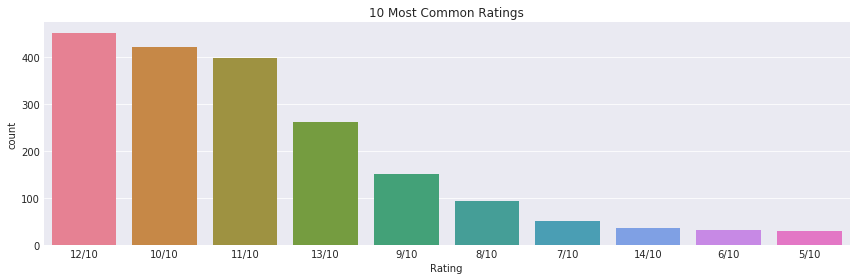

In [4]:
plt.figure(figsize=(12,4))
sns.countplot(t_master.rating, order=t_master.rating.value_counts().iloc[:10].index, palette= 'husl', )
plt.xlabel('Rating')
plt.title('10 Most Common Ratings')
plt.tight_layout()

* Most dogs have ratings above 10/10, although there are a few that have ratings under 10. Knowing how the dog ratings work, this is most likely either due to data input error or simply that the twitter user doesn't necessarily get that dogs are good boys and deserve at least a 10/10
* Quite a lot of very good boys, with most ratings above 10/10

Descriptive Stats of Retweet Count 
count     1991.000000
mean      2733.593672
std       4717.938961
min         13.000000
25%        612.500000
50%       1318.000000
75%       3139.000000
max      77707.000000
Name: retweet_count, dtype: float64


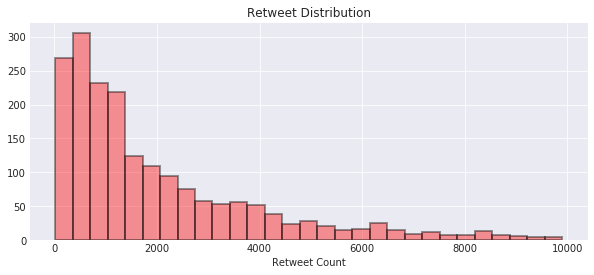

In [81]:
retweet_count_limited = t_master[t_master['retweet_count'] <= 10000]

plt.figure(figsize=(10,4))
sns.distplot(retweet_count_limited['retweet_count'], kde = False, color='red',
             hist_kws=dict(edgecolor="k", linewidth=2) )
plt.xlabel('Retweet Count')
plt.title('Retweet Distribution')
print('Descriptive Stats of Retweet Count \n' + str(t_master.retweet_count.describe()))

* Most submissions are retweeted less than 2000 times, although this could be a factor of how long a post has been on twitter and not necessarily how popular a post is
* There is a post in this dataset with 77,707 retweets!

Descriptive Stats of p1 confidence 
count    1991.000000
mean        0.593676
std         0.271945
min         0.044333
25%         0.362716
50%         0.587507
75%         0.844583
max         1.000000
Name: p1_conf, dtype: float64


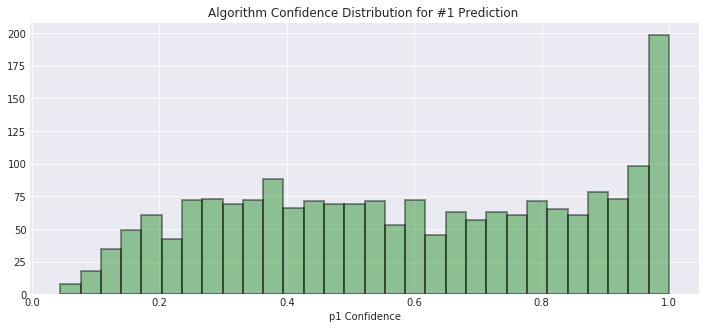

In [82]:
plt.figure(figsize=(12,5))
sns.distplot(t_master.p1_conf, kde=False, bins = 30, color='green',
             hist_kws=dict(edgecolor="k", linewidth=2) )
plt.xlabel('p1 Confidence')
plt.title('Algorithm Confidence Distribution for #1 Prediction ')
print('Descriptive Stats of p1 confidence \n' + str(t_master.p1_conf.describe()))

* The model does seem to be an okay fit, where the first image predictions are somewhat accurate for a good amount of the total submissions. However, you do have a lot of entries that are below a 70% confidence rating, some lower than 20%!
* Perhaps more feature engineering needs to be done to create a more accurate neural network algorithm

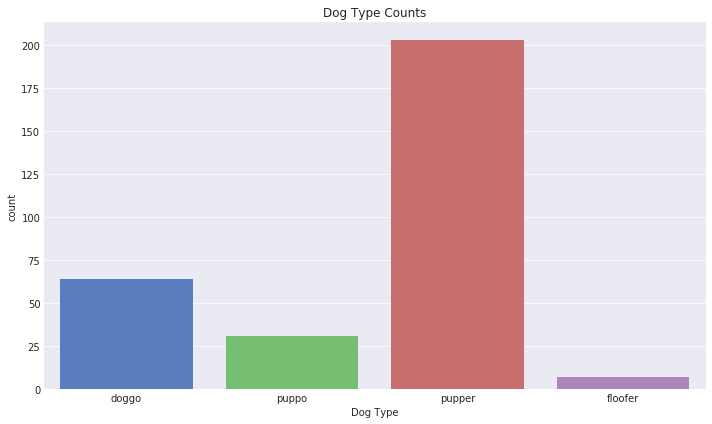

In [83]:
dog_typesNotNull = t_master[(t_master['dog_type'] != 'None') & 
                            (t_master['dog_type'] != 'doggo/floofer')]


plt.figure(figsize=(10,6))
sns.countplot(dog_typesNotNull['dog_type'], palette = 'muted')
plt.xlabel('Dog Type')
plt.title('Dog Type Counts')
plt.tight_layout()

* Not a whole lot of dogs have category types in the dataset, some reasons for this could be attributed to missing user input or scraping the data from twitter wasn't entirely accurate.
* Lots of puppers in the data compared to doggos and puppos. Floofers don't seem to be as common